In [17]:
# for dealing with data
import pandas as pd
import numpy as np
import random


# for visualization
from matplotlib import pyplot as plt
import seaborn as sns


# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import RandomizedSearchCV


# Mathematics library
import math


# for statisticals tools 
from scipy import stats
import scipy as sci
from scipy.spatial.distance import minkowski


# helpers file
from preprocessing_helper import *
from sampling_helper import *
from metrics_helper import *


# we set the dimensions of the plots
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')
#%cd drive/My\ Drive

# Preprocessing

### Dataset import

In [5]:
# we import the dataset using pandas
df = pd.read_csv('../data/GSM1586785_ScrH-12A_Exd_14mer_cg.csv')

In [6]:
# we visualize the first ten rows of our dataframe
df.head(10)

,Unnamed: 0,Kmer,y_1,y_2,y_3,y_4,y_5,y_6,zC_1,zC_2,...,zW_76,zW_77,zW_78,y_79,y_80,y_81,y_82,y_83,y_84,relKa
0,0,AATGATTAATTACC,0.593697,-1.092779,0.309117,0.133525,0.023403,-0.157348,1.177586,-2.166888,...,-0.674709,10.019444,-1.012806,-0.790300,-0.112492,0.118705,0.237596,-0.009713,0.267886,1.000000
1,1,GGTAATTAATCATT,0.790300,-0.112492,0.118705,-0.237596,-0.009713,0.267886,2.591673,-3.422281,...,-0.986852,9.851130,-1.990198,-0.593697,-1.092779,0.309117,-0.133525,0.023403,-0.157348,1.000000
2,2,AATGATTAATTACT,0.593690,-1.092780,0.309116,0.133525,0.023403,-0.157348,1.177587,-2.166890,...,-0.839165,10.065669,-1.499679,-0.826872,-1.141872,0.500342,-0.143809,0.043456,0.095141,0.968830
3,3,AGTAATTAATCATT,0.826872,-1.141872,0.500342,0.143809,0.043456,0.095141,2.137980,-2.777053,...,-0.986851,9.851129,-1.990198,-0.593690,-1.092780,0.309116,-0.133525,0.023403,-0.157348,0.968830
4,4,AGGTAATTAATCAT,1.260372,-0.870861,0.397555,0.124897,0.053255,0.213696,1.977567,-2.851909,...,-0.960712,9.943948,-1.806082,0.336528,-0.596511,0.184099,-0.075285,0.032807,0.149085,0.968752
5,5,ATGATTAATTACCT,-0.336528,-0.596511,0.184099,0.075285,0.032807,0.149085,1.689293,-2.713471,...,-0.880962,10.025845,-1.642795,-1.260372,-0.870861,0.397555,-0.124897,0.053255,0.213696,0.968752
6,6,GAATGATTAATTAC,0.913065,-0.050248,0.143538,-0.223040,0.018513,0.150335,1.664473,-2.791084,...,-1.250065,9.932713,-1.650592,0.378019,-0.119601,0.143364,0.200255,-0.000247,0.258814,0.962931
7,7,GTAATTAATCATTC,-0.378019,-0.119601,0.143364,-0.200255,-0.000247,0.258814,0.834275,-1.606688,...,-0.909342,9.914885,-1.620308,-0.913065,-0.050248,0.143538,0.223040,0.018513,0.150335,0.962931
8,8,AAGTAATTAATCAT,1.120371,-1.103292,0.321935,0.118111,0.038891,-0.068592,1.112401,-2.117575,...,-0.960720,9.943946,-1.806092,0.336478,-0.596498,0.184103,-0.075283,0.032807,0.149103,0.962317
9,9,ATGATTAATTACTT,-0.336478,-0.596498,0.184103,0.075283,0.032807,0.149103,1.689279,-2.713457,...,-1.116182,9.884140,-2.053728,-1.120371,-1.103292,0.321935,-0.118111,0.038891,-0.068592,0.962317


The dataframe has 321 columns, the column "Unnamed:0" corresponds clearly to the indices of our dataframe so it doesn't carry any additional information (we will drop it soon), the column "Kmer" contains the DNA sequences corresponding to each datapoint (a protein). The column "relKa" represents the probability that the protein is a binding site or not and it is a number from zero to one coming from experiments. Finally, the other columns are mechanical properties of the protein.

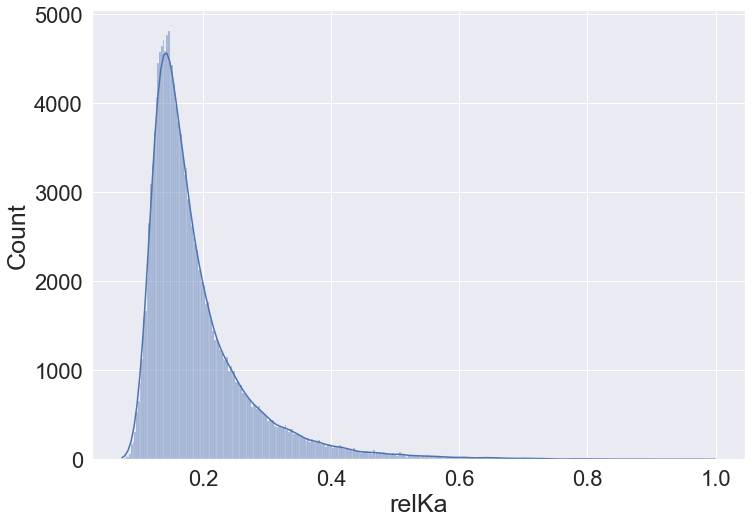

In [7]:
# we plot the distribution of the target label

sns.set(font_scale=2)
p = sns.histplot(data = df.relKa, kde=True)
p.set_xlabel("relKa", fontsize = 25) ## we want the labels to be big because we will use this plots in the report
p.set_ylabel("Count", fontsize = 25)
plt.show()

As we can observe the distribution is very skewed. Indeed, there are very few datapoints with a relKa bigger than 0.7. This makes our task quite hard since it is hard for a machine learning model to learn in the range of relKas between 0.7 and 1 because we have few datapoints in that range.

In [8]:
df.drop(columns = 'Unnamed: 0', inplace = True) # we drop the column with the indices
df.drop(columns = 'Kmer', inplace = True) # we drop the column with DNA sequences

We also tried to encode the DNA sequence instead of dropping with one hot encoding or sequential encoding but the final results were slightly worse.

### Splitting the dataset

In [9]:
# we divide our dataset in y labels and x label

y = df['relKa'].to_numpy()
x = df.loc[:, df.columns != 'relKa'].to_numpy()

In [10]:
# we split the x and y in x_0, x_1, y_0, y_1 where x_0 are all the features of the points with relka between 0 and 0.7, 
# x_1 are all the features of the points with relka between 0.7 and 1 and y_0,y_1 are the relKa corresponding to the two groups
# respectively


x_1,y_1,x_0,y_0 = split_importance(x,y)

In [11]:
# split the two classes seperately into train and test set to ensure representation of the minority class
# both in the test set and in the train set
x_1_train, x_1_test, y_1_train, y_1_test = train_test_split(x_1, y_1, test_size=0.3, random_state=42)
x_0_train, x_0_test, y_0_train, y_0_test = train_test_split(x_0, y_0, test_size=0.3, random_state=42) # fede aveva messo 0.4

x_train = np.concatenate((x_1_train, x_0_train))
y_train = np.concatenate((y_1_train, y_0_train))
x_test = np.concatenate((x_1_test, x_0_test))
y_test = np.concatenate((y_1_test, y_0_test))

### Outliers remotion

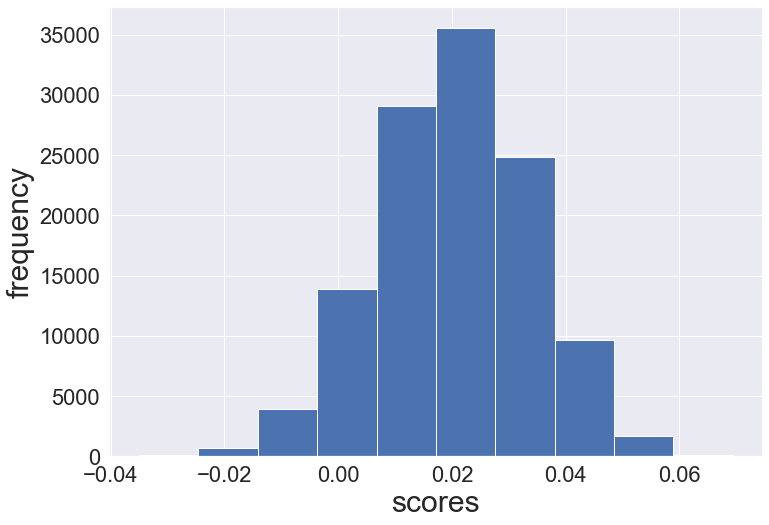

The indecision percentage around 0.02 is 0.47895415640755074
The percentage of outliers detected is 0.06591796057149557


In [12]:
# we apply the algorithm for outliers remotion
contamination, scores, outliers_indices = Anomaly_Detection_Isolation_Forests(x_train, change_split=False)

# we check that the algorithm is working properly
check_Isolation_Forests(contamination, outliers_indices, y_train)

# we plot the distribution of the scores
check_boundary_decision(scores, 0.02, verbose=1)

In [13]:
# we drop the outliers
x_train, y_train = drop_outliers(x_train, y_train, outliers_indices)

### Features scaling

In [14]:
# we create a scaler
sc = StandardScaler()

# we fit and scale on the train (we work with the mean and the std of the train)
x_train = sc.fit_transform(x_train)

# we use the same scaler (same mean and same std to scale the validation and the test set)
x_test = sc.transform(x_test)

### Create the labels

In [15]:
## Now we transform the RelKa in labels:

# The relKa values belonging to [0.7,1] will be labelled as 1
# The relKa values belonging to [0,0.7] will be labelled as 0

y_train = split_RelKa(y_train, 0.7)
y_test = split_RelKa(y_test, 0.7)

### Sampling

In [ ]:
x_train, y_train = smote_sf_classification(x_train, y_train)

### Training

In [ ]:
clf = RandomForestClassifier(n_estimators = 150, min_samples_split = 2, min_samples_leaf = 1)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
return_accuracy(y_test, y_pred, verbose=1)